### Import packages 

In [6]:
from ml_utils import *
from QC import *
sc.settings.set_figure_params(dpi=100)

In [68]:
# reload fcc module while working
import sys
del sys.modules['ml_utils']
from ml_utils import *

Read in normal human colon sample

In [2]:
%time s1 = sc.read('/Users/cody/Dropbox (VU Basic Sciences)/workspace/human_crc_09Aug19/raw/3247-AS-1-GCCAAT_S1_counts.tsv.gz')

CPU times: user 1min 14s, sys: 1.38 s, total: 1min 15s
Wall time: 1min 15s


In [3]:
# get number of cells and genes in dataset
s1.shape

(19128, 41569)

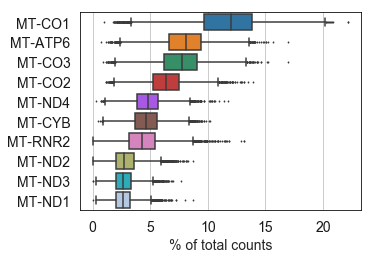

In [4]:
# look at highest expression by gene across all cells
sc.pl.highest_expr_genes(s1, n_top=10)

Looks like a lot of dead cells (high mitochondrial counts).  
Let's create some useful observations in our `AnnData` objects.

In [7]:
# get total counts for each observation (cell)
s1.obs['n_counts'] = s1.X.sum(axis=1) 

# get total number of genes detected for each observation (cell)
s1.obs['n_genes'] = s1.X.astype(bool).sum(axis=1)

# quick reordering of AnnData object, since our analysis assumes libraries sorted from highest to lowest quality
reorder_AnnData(s1)

# create new "observations" of percent mito reads per cell
mito_genes = s1.var_names.str.startswith('MT-') 
s1.obs['percent_mito'] = np.sum(s1[:, mito_genes].X, axis=1) / s1.obs['n_counts']

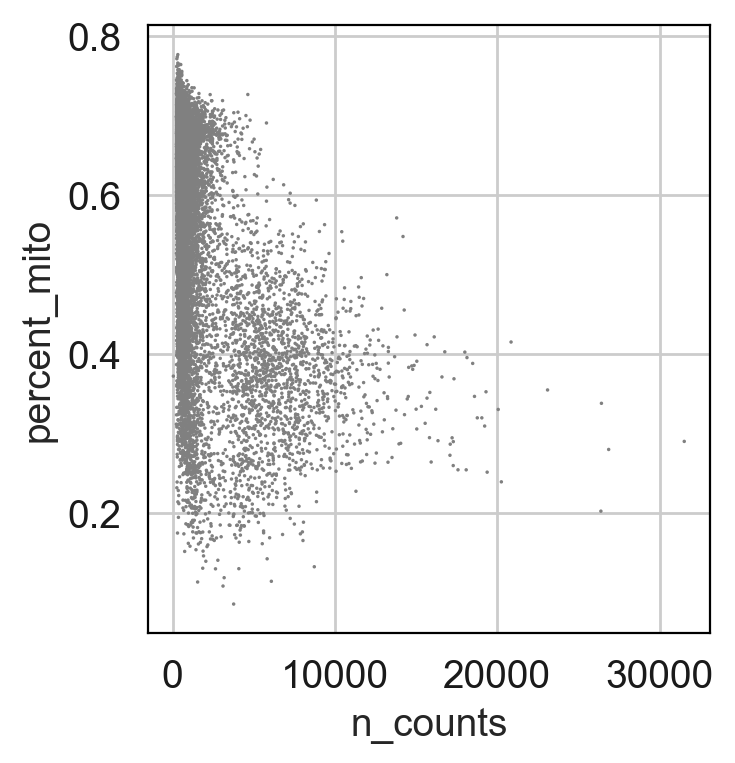

In [8]:
# look at low-quality and dead cell distribution
sc.pl.scatter(s1, x='n_counts', y='percent_mito')

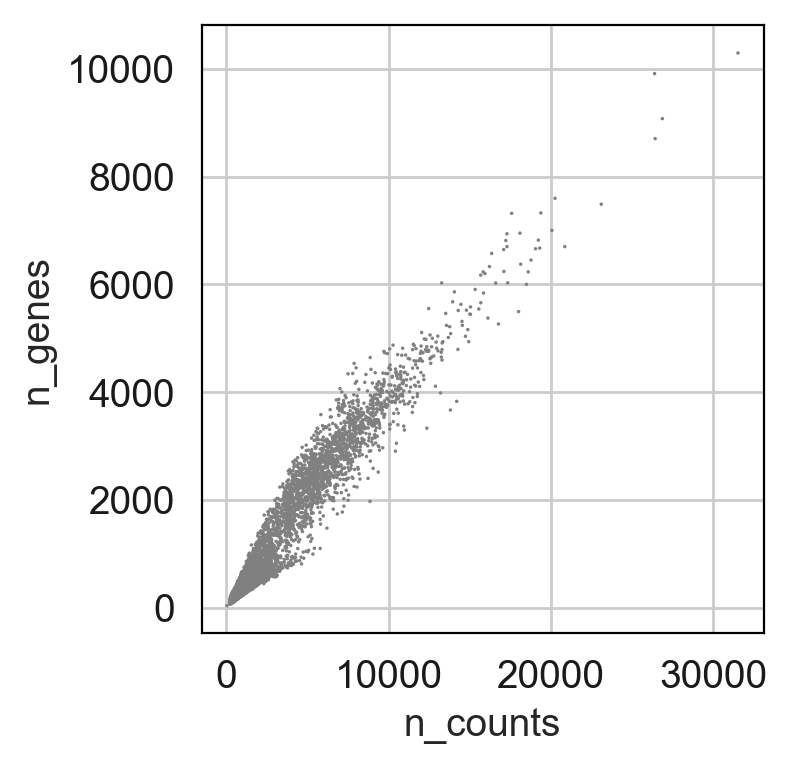

In [9]:
sc.pl.scatter(s1, x='n_counts', y='n_genes')

In [10]:
s1.raw = s1 # checkpoint before normalizing and scaling data

### Find inflection point

Inflection point at bcEGRW     3541
bcIJCL     2348
bcBEDN     7392
bcEFCU    10593
bcDZKU    19127
Name: n_counts, dtype: int64 for [0, 15, 30, 50, 100] percentiles of greatest secant distances


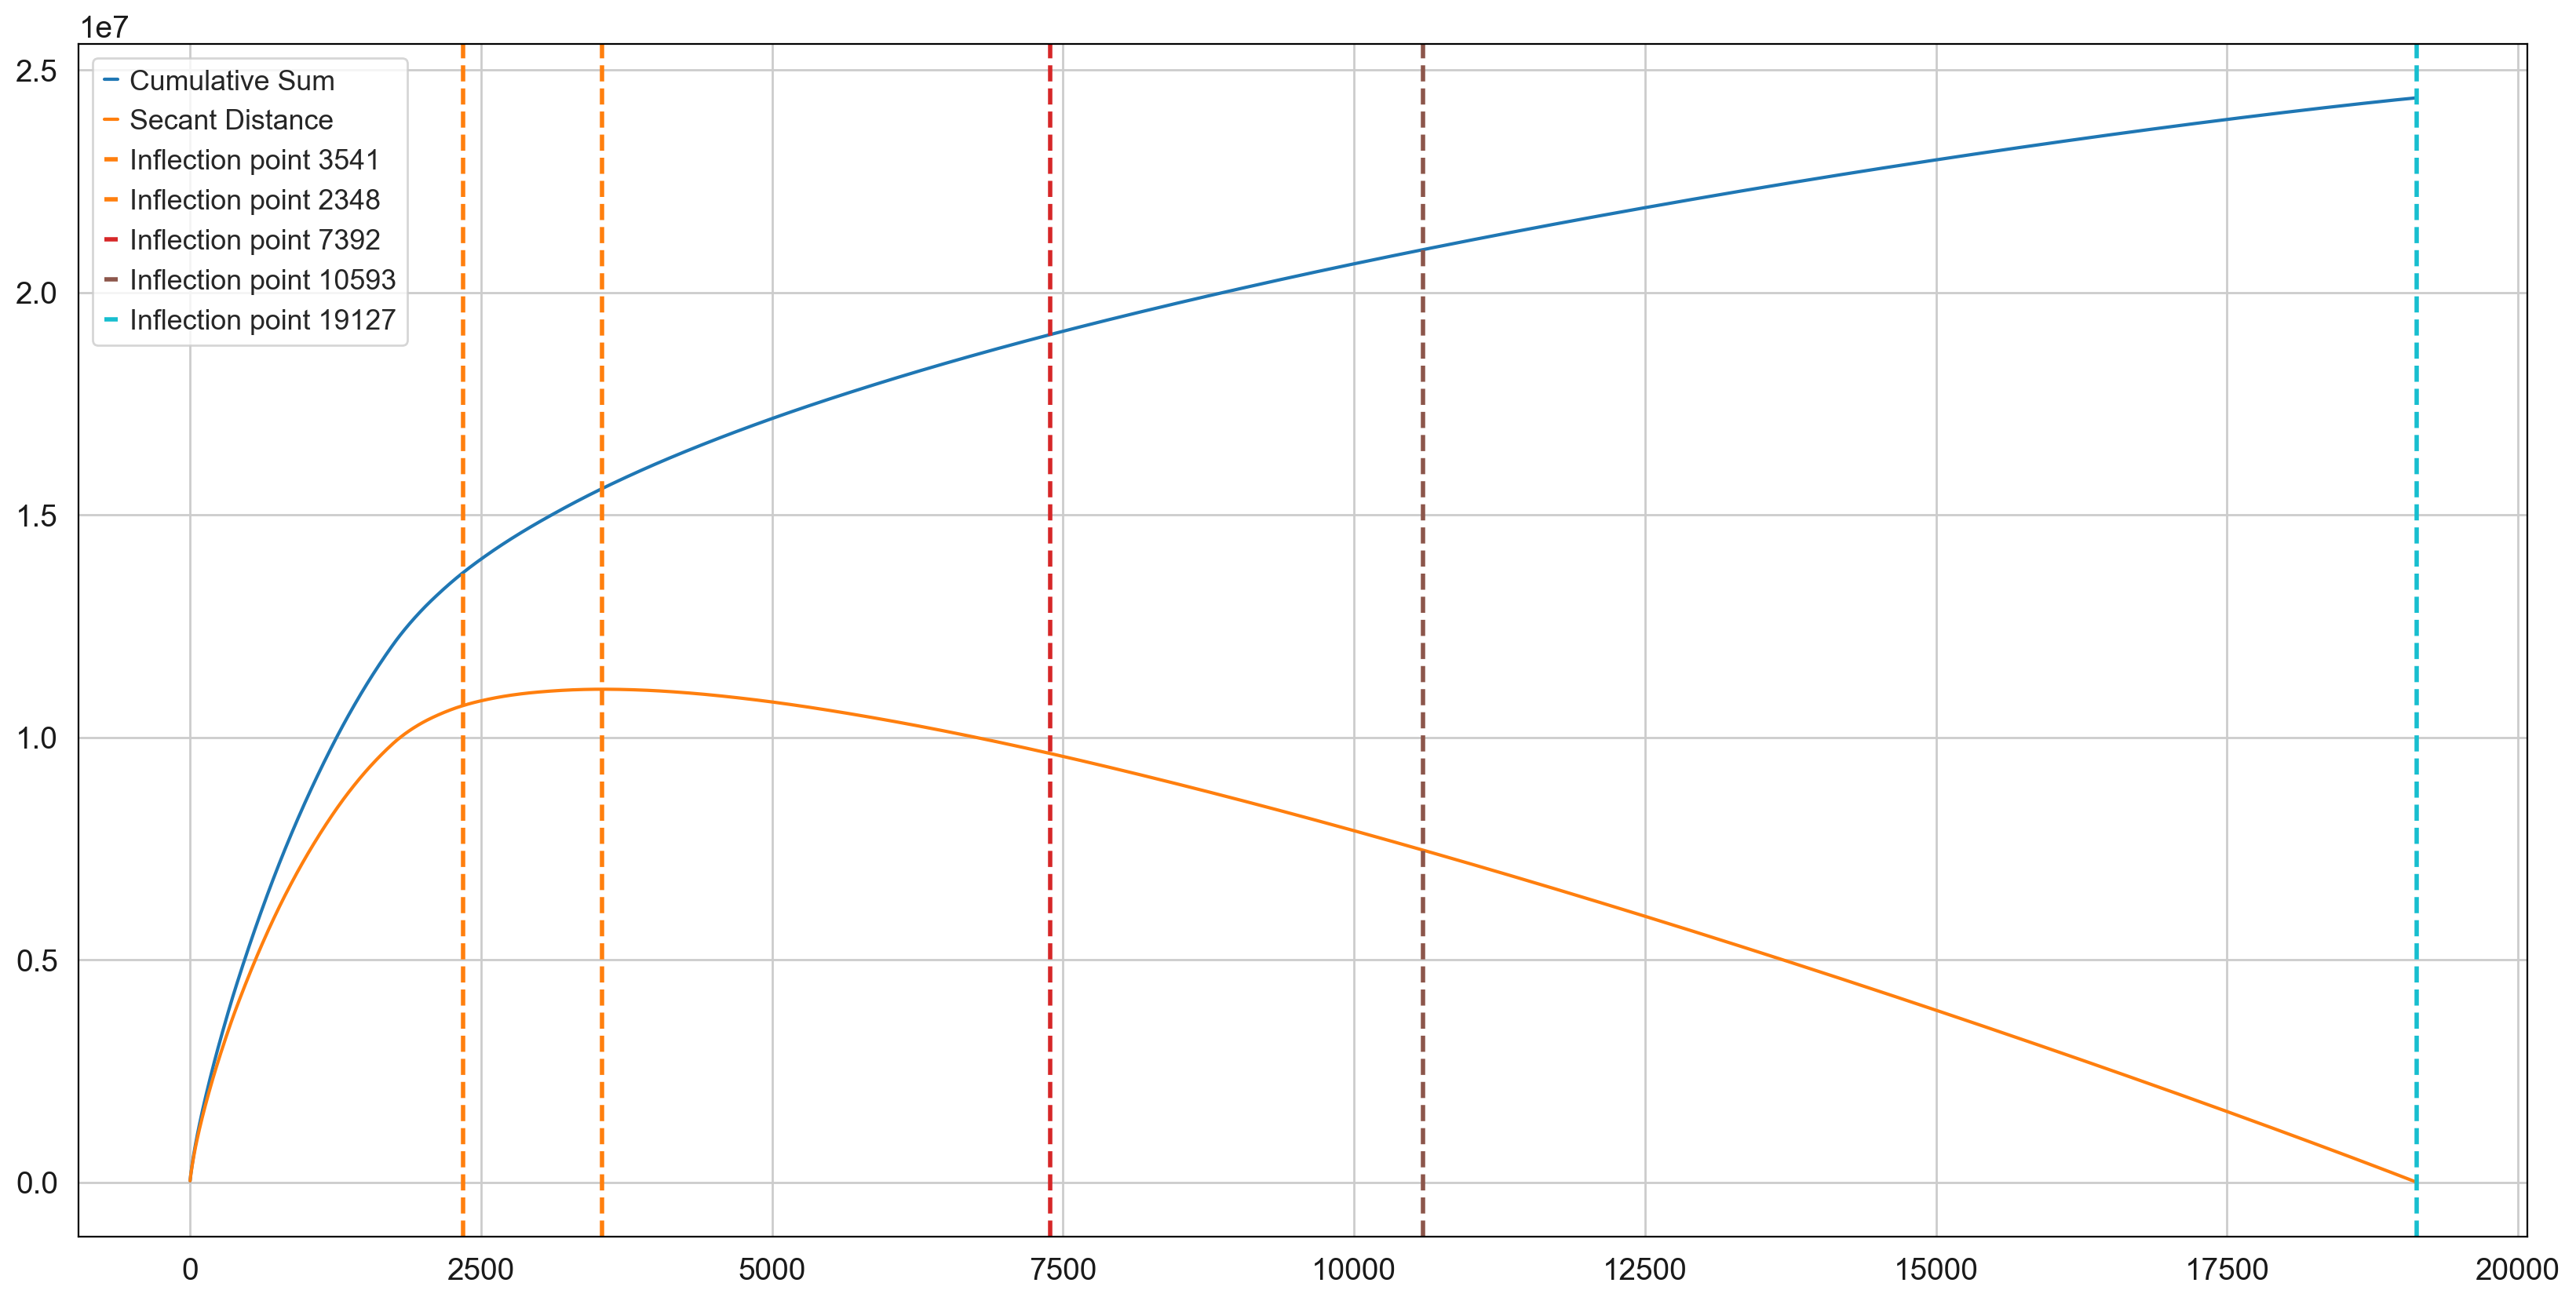

In [11]:
find_inflection(s1, inflection_percentiles = [0,15,30,50,100])

Let's not filter cells just yet - see how they cluster after dimensionality reduction

In [12]:
s1.obs['n_counts'][7392] # see the total counts for the cutoff point

682.0

Cutoff for `emptyDrops` should be at the number of counts above.   
Let's read in  `emptyDrops` predictions and filter out, then ID dead cells.

In [76]:
emptydrops = pd.read_csv('3247-AS-1-GCCAAT_S1_emptydrops.csv')

In [77]:
emptydrops.index = emptydrops['barcode']

In [78]:
# create new "observation" as empty droplet label
s1.obs['empty'] = emptydrops['empty']

In [79]:
s1.obs['dead'] = np.where(s1.obs['percent_mito']>=0.5, 1, 0)

In [80]:
s1.obs['live'] = np.where((s1.obs['empty']==0) & (s1.obs['dead']==0), 1, 0)

In [81]:
s1.obs['label'] = np.where(s1.obs['live']==1, 'alive', 'dead')
s1.obs.loc[s1.obs['empty']==1,'label'] = 'empty'

---
### Machine Learning Classifiers

In [20]:
%%time
sc.pp.normalize_total(s1) #each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) #log1p normalization
sc.pp.scale(s1) #scaling by variance and centering to zero for visualization
sc.tl.pca(s1, n_comps=100) #performing PCA

CPU times: user 1min 54s, sys: 5.62 s, total: 2min
Wall time: 26.5 s


In [21]:
s1.obsm['X_pca'].shape

(19128, 100)

Test using wrapper function from `ml_utils.py`

In [82]:
s1.obs['label'].unique() # order of labels for plots

array(['alive', 'dead', 'empty'], dtype=object)

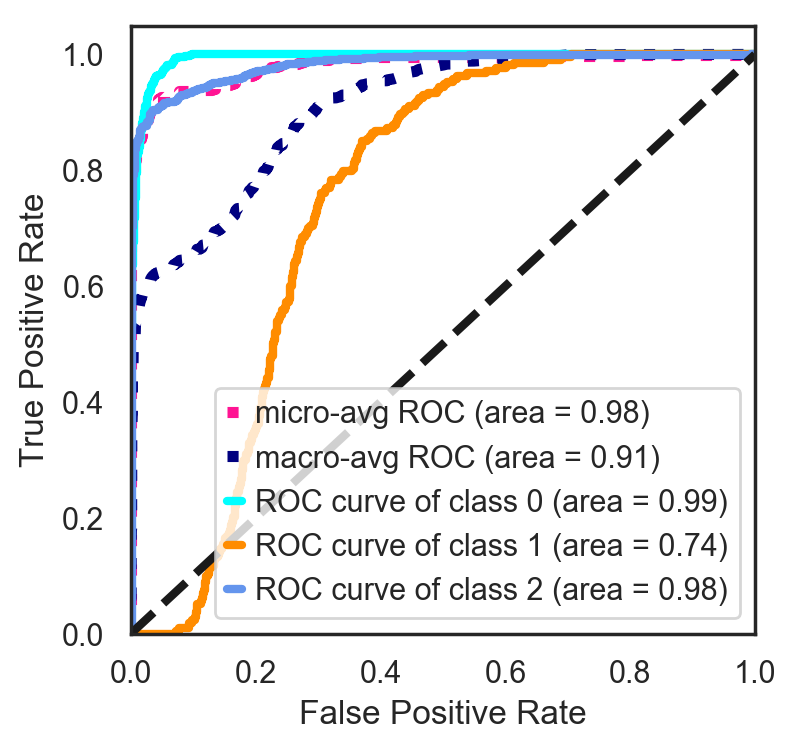

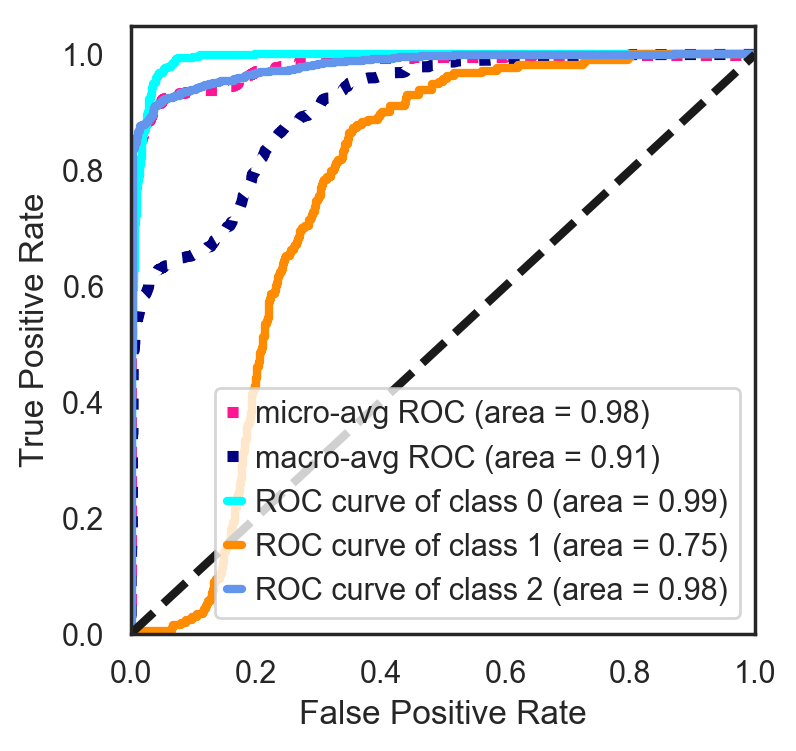

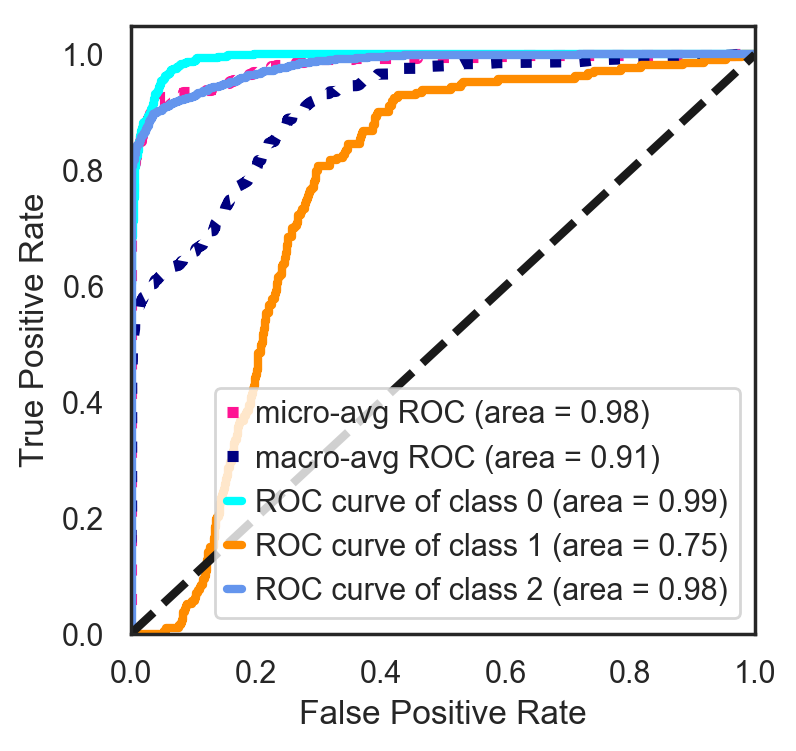

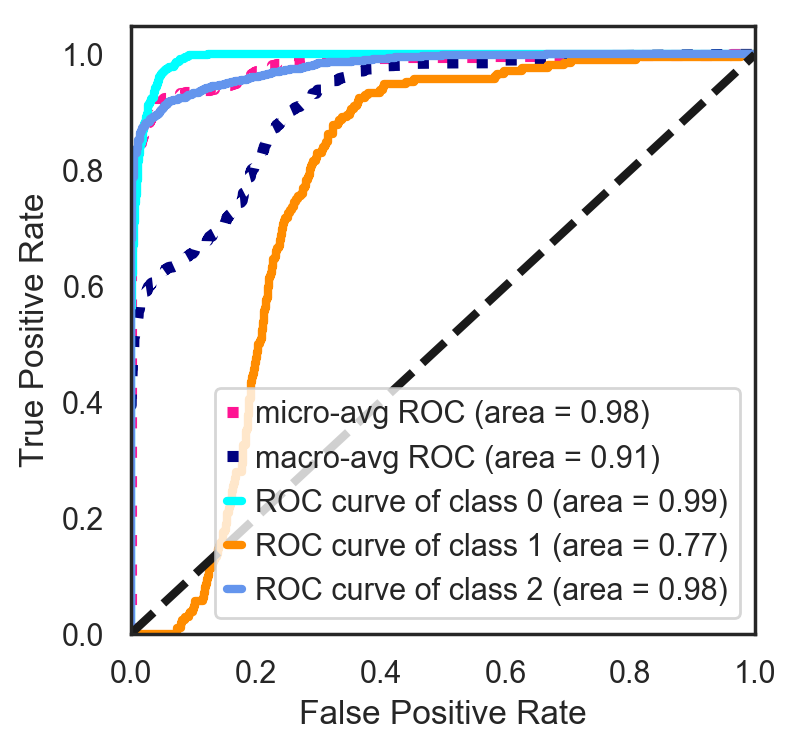

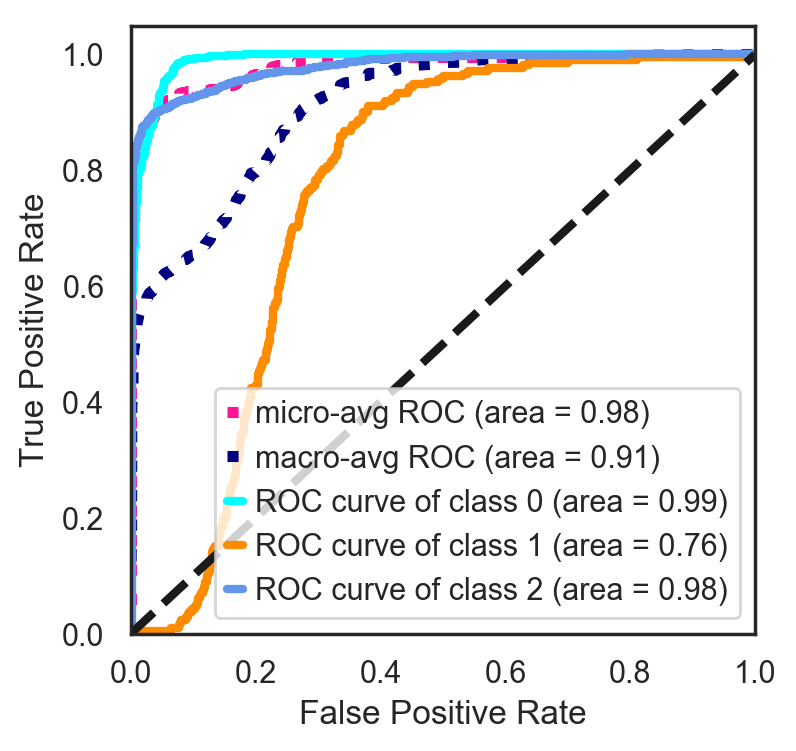

CPU times: user 3min 5s, sys: 13.2 s, total: 3min 18s
Wall time: 34.2 s


In [83]:
%%time
# Logistic Regression Classifier
lr = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial', max_iter=1000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

for train, test in cv.split(s1.obsm['X_pca'], s1.obs['label']):
    mets = multiclass_roc(clf=lr, X_train=s1.obsm['X_pca'][train], X_test=s1.obsm['X_pca'][test], y_train=s1.obs['label'][train], y_test=s1.obs['label'][test])

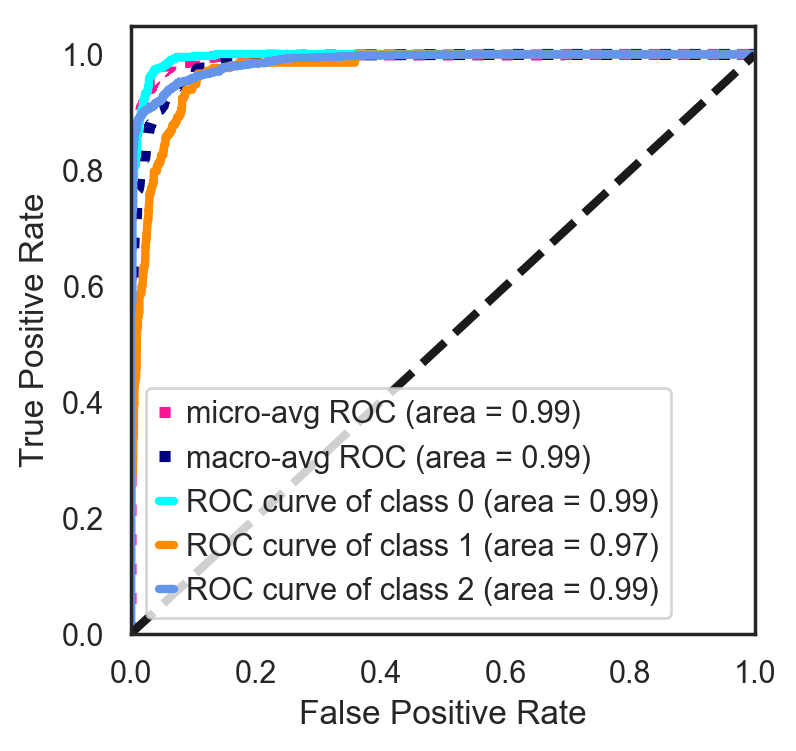

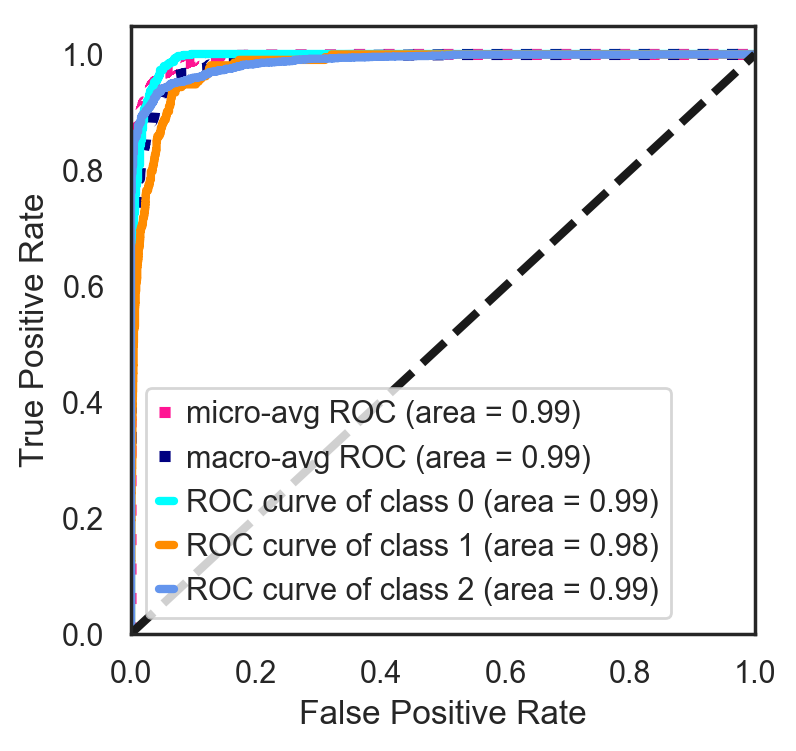

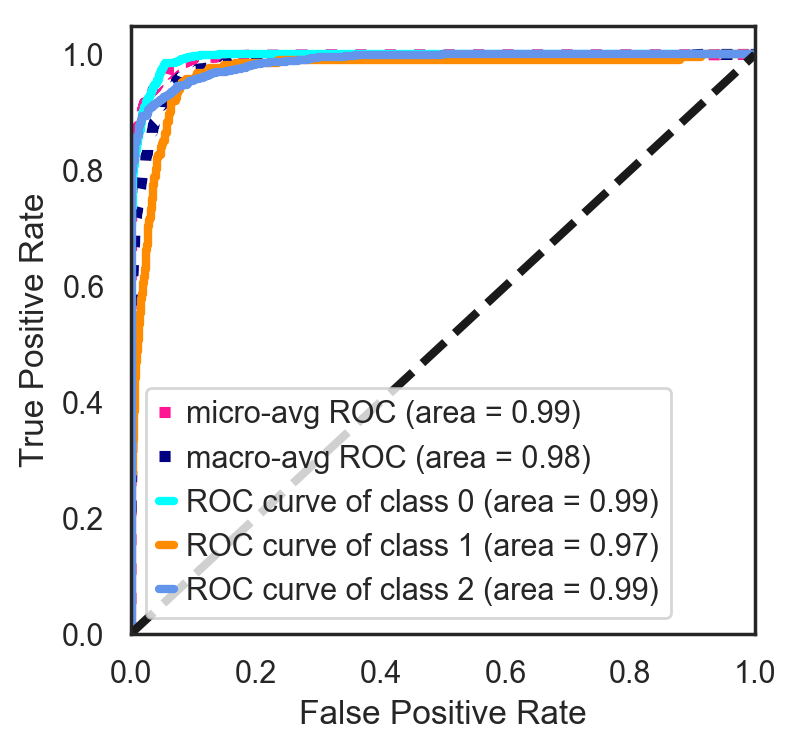

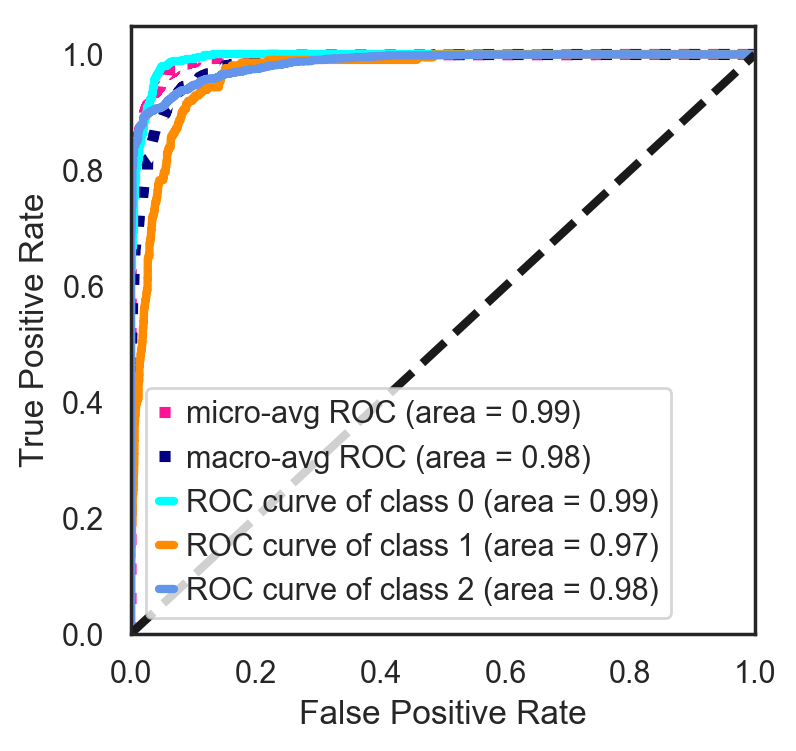

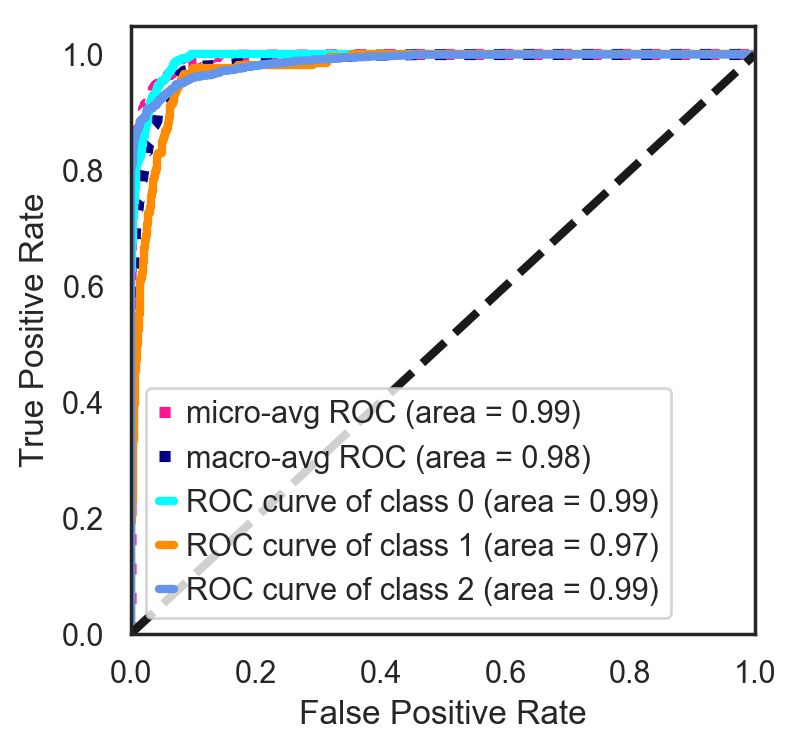

CPU times: user 2min 38s, sys: 297 ms, total: 2min 39s
Wall time: 2min 37s


In [84]:
%%time
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()

for train, test in cv.split(s1.obsm['X_pca'], s1.obs['label']):
    mets = multiclass_roc(clf=gbc, X_train=s1.obsm['X_pca'][train], X_test=s1.obsm['X_pca'][test], y_train=s1.obs['label'][train], y_test=s1.obs['label'][test])

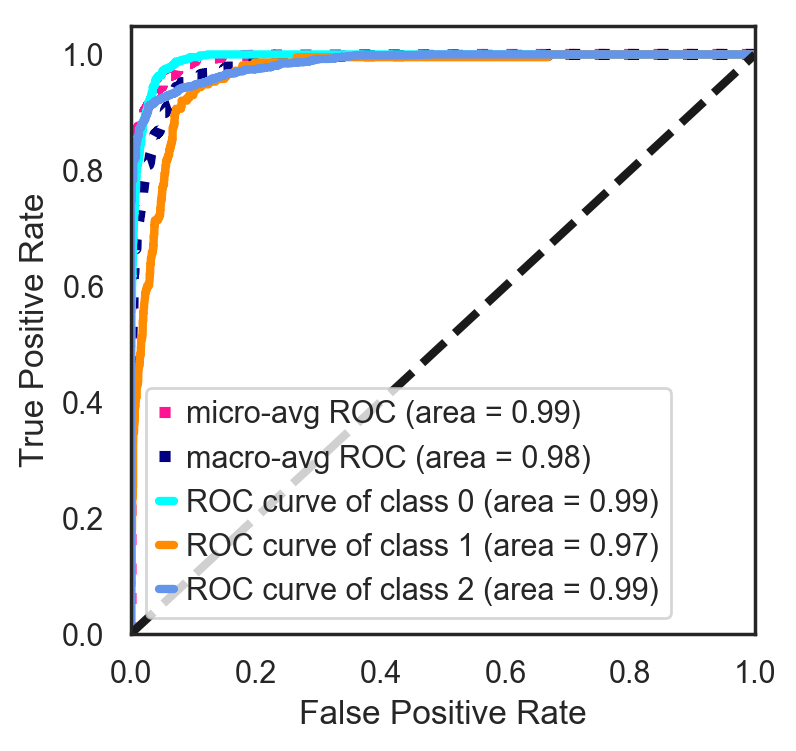

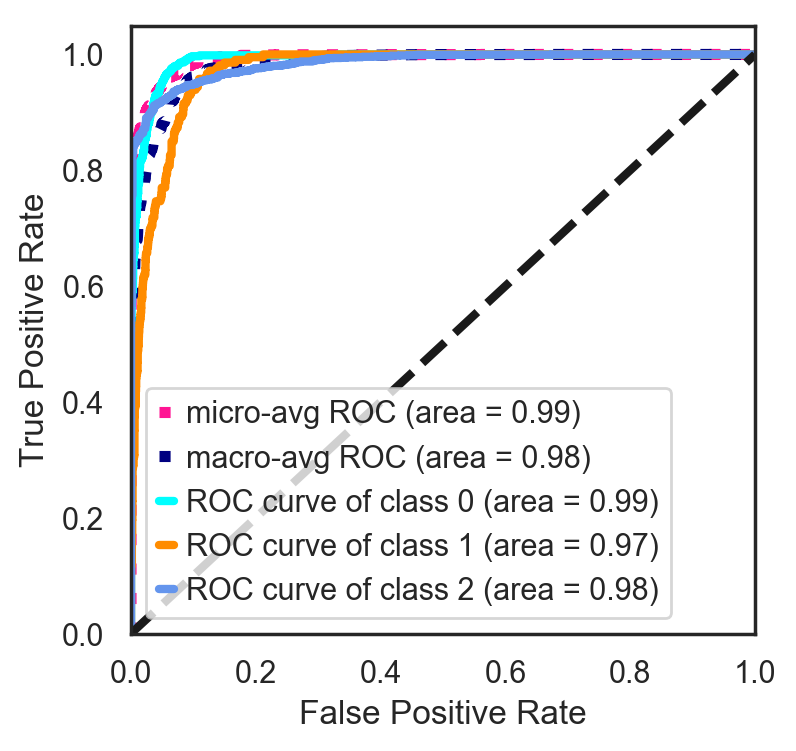

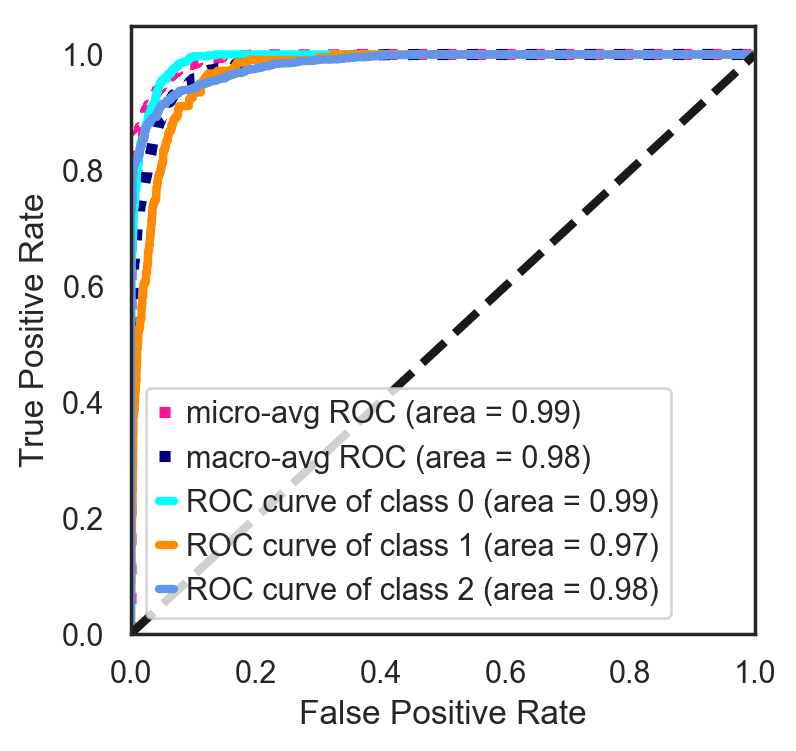

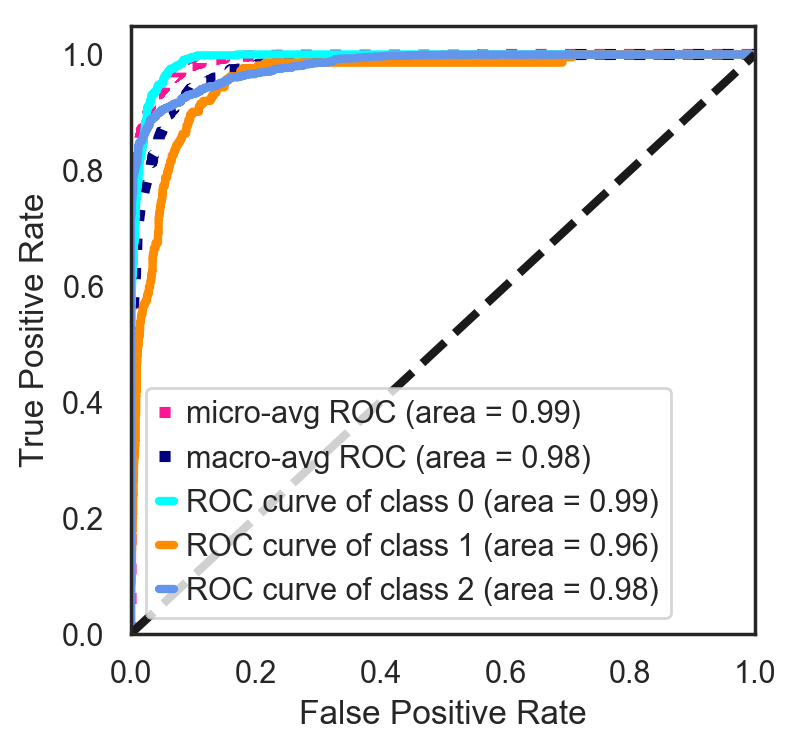

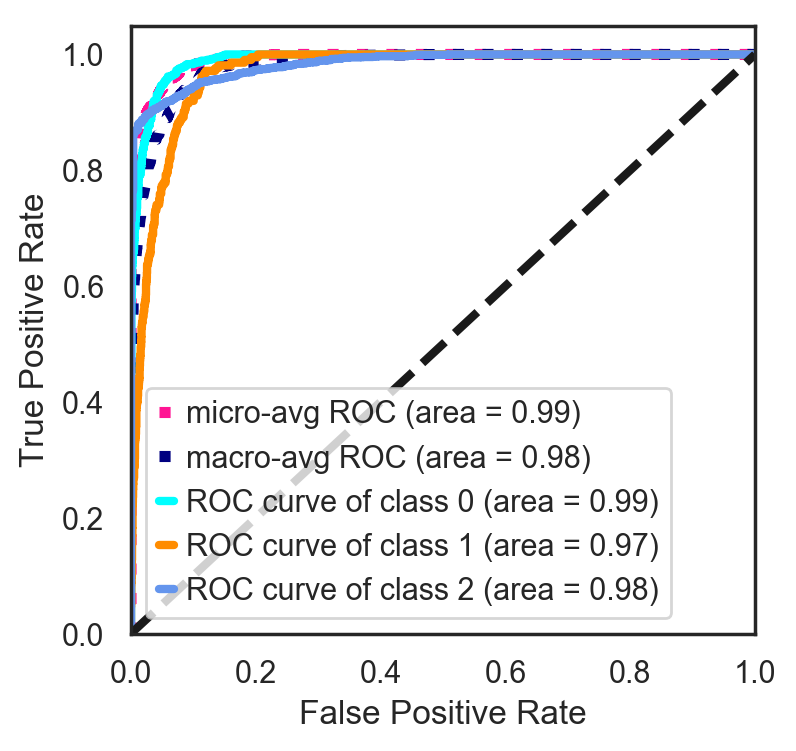

CPU times: user 1min 41s, sys: 260 ms, total: 1min 41s
Wall time: 1min 39s


In [85]:
%%time
# AdaBoost Classifier
abc = AdaBoostClassifier()

for train, test in cv.split(s1.obsm['X_pca'], s1.obs['label']):
    mets = multiclass_roc(clf=abc, X_train=s1.obsm['X_pca'][train], X_test=s1.obsm['X_pca'][test], y_train=s1.obs['label'][train], y_test=s1.obs['label'][test])

---

So it looks like the __Gradient Boosting Classifier__ is our best bet based on AUROC and Accuracy values.  
Now, we can optimize the hyperparameters using `RandomizedSearchCV` to tweak the classifier for the best result and compare optimized classifier.

In [145]:
from pprint import pprint

In [146]:
# Generate grid of hyperparameters to test
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
loss = ['deviance', 'exponential']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# learning rate
learning_rate = np.linspace(0.1, 1, 10)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'loss': loss,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}
pprint(random_grid)

{'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'loss': ['deviance', 'exponential'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [147]:
%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gbc = GradientBoostingClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=18, n_jobs = -1)
# Fit the random search model
gbc_random.fit(s1.obsm['X_pca'], s1.obs['alive'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.2s
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.3min finished


CPU times: user 26.2 s, sys: 980 ms, total: 27.2 s
Wall time: 12min 37s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [148]:
gbc_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 70,
 'loss': 'exponential',
 'learning_rate': 0.30000000000000004}

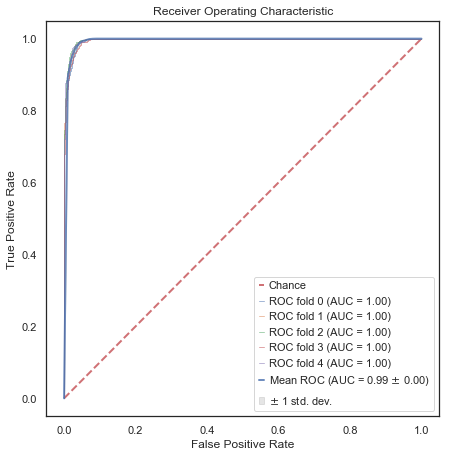

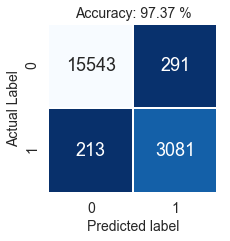

In [149]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features='auto', max_depth=70, loss='exponential', learning_rate=0.3)
mets = roc_kfold(clf=gbc, X=s1.obsm['X_pca'], y=s1.obs['alive'], k=5, seed=18)